# Задача

В нашем распоряжении данные 500 пользователей федерального оператора сотовой связи «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Чтение и знакомство с данными

Данные хранятся в 5 файлах:  
1. Calls - информация о звонках  
2. Internet - информация об интернет-сессиях
3. Messages - информация о сообщениях
4. Tariffs - информация о тарифах
5. Users - информация о пользователях

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt
from math import factorial
from scipy import stats as st

In [2]:
calls = pd.read_csv('calls.csv')

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
internet = pd.read_csv('internet.csv')

In [5]:
del internet['Unnamed: 0']

In [6]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [7]:
messages = pd.read_csv('messages.csv')

In [8]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
tariffs = pd.read_csv('tariffs.csv')

In [10]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
users = pd.read_csv('users.csv')

In [12]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


# Подготовка данных

Приведем все столбцы к правильному типу данных 

In [13]:
calls.dtypes

id            object
call_date     object
duration     float64
user_id        int64
dtype: object

In [14]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [15]:
internet.dtypes

id               object
mb_used         float64
session_date     object
user_id           int64
dtype: object

In [16]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [17]:
messages.dtypes

id              object
message_date    object
user_id          int64
dtype: object

In [18]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [19]:
users.dtypes

user_id        int64
age            int64
churn_date    object
city          object
first_name    object
last_name     object
reg_date      object
tariff        object
dtype: object

In [20]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [21]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

# Добавление столбцов

## Количество сделанных звонков и израсходованных минут разговора по месяцам

In [22]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Добавим столбец где будут храниться месяцы звонка

In [23]:
calls['call_date_month'] = calls['call_date'].dt.to_period('M')

Сгруппируем данные по user_id и месяцу

In [24]:
calls_pivot = pd.pivot_table(calls, index=['user_id', 'call_date_month'], values='duration', aggfunc=['count', 'sum']).reset_index()

In [25]:
calls_pivot.columns = ['user_id', 'call_date_month', 'call_count_month', 'call_duration_month']

In [26]:
calls_pivot.head()

,user_id,call_date_month,call_count_month,call_duration_month
0,1000,2018-05,22,150.06
1,1000,2018-06,43,158.90
2,1000,2018-07,47,318.80
3,1000,2018-08,52,389.87
4,1000,2018-09,58,440.14


Округлим значения столбца call_duration_month 

In [27]:
calls_pivot['call_duration_month'] = np.ceil(calls_pivot['call_duration_month'])

In [28]:
calls_pivot['call_duration_month'] = calls_pivot['call_duration_month'].astype('int')

In [29]:
calls_pivot.head()

,user_id,call_date_month,call_count_month,call_duration_month
0,1000,2018-05,22,151
1,1000,2018-06,43,159
2,1000,2018-07,47,319
3,1000,2018-08,52,390
4,1000,2018-09,58,441


Проверим на наличие аномалий

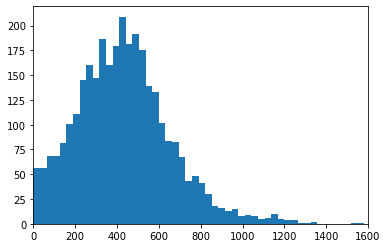

In [30]:
plt.hist(calls_pivot['call_duration_month'], bins=50)
plt.xlim([0,1600])
plt.show()

Есть нулевые значения, хотя мы все значения округляли в большую сторону. Проверим почему так

In [31]:
calls_pivot[calls_pivot['call_duration_month'] == 0]

,user_id,call_date_month,call_count_month,call_duration_month
1493,1240,2018-02,2,0
1605,1257,2018-07,1,0
1606,1257,2018-08,2,0
1607,1257,2018-09,1,0
2318,1373,2018-01,2,0
2321,1373,2018-04,1,0


Нулевая длительность звонков у пользователей, которые звонили (или им звонили) всего 1-2 раза в месяц. По-моему они просто не брали трубку или находились за границей и были недоступны. Оставим эти значения как есть

Добавим в таблицу calls данные из сводной таблицы

In [32]:
calls = calls.merge(calls_pivot, on=['user_id', 'call_date_month'], how='left')

In [33]:
calls.head()

,id,call_date,duration,user_id,call_date_month,call_count_month,call_duration_month
0,1000_0,2018-07-25,0.00,1000,2018-07,47,319
1,1000_1,2018-08-17,0.00,1000,2018-08,52,390
2,1000_2,2018-06-11,2.85,1000,2018-06,43,159
3,1000_3,2018-09-21,13.80,1000,2018-09,58,441
4,1000_4,2018-12-15,5.18,1000,2018-12,46,313


Проделаем то же самое с количеством сообщений и объемом интернет-трафика

## Количество отправленных сообщений по месяцам

In [34]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [35]:
messages['message_date_month'] = messages['message_date'].dt.to_period('M')

In [36]:
messages_pivot = pd.pivot_table(messages, index=['user_id', 'message_date_month'], values='message_date', aggfunc='count').reset_index()

In [37]:
messages_pivot.columns = ['user_id', 'message_date_month', 'message_count_month']

In [38]:
messages_pivot.head()

,user_id,message_date_month,message_count_month
0,1000,2018-05,22
1,1000,2018-06,60
2,1000,2018-07,75
3,1000,2018-08,81
4,1000,2018-09,57


In [39]:
messages = messages.merge(messages_pivot, on=['user_id', 'message_date_month'], how='left')

In [40]:
messages.head()

,id,message_date,user_id,message_date_month,message_count_month
0,1000_0,2018-06-27,1000,2018-06,60
1,1000_1,2018-10-08,1000,2018-10,73
2,1000_2,2018-08-04,1000,2018-08,81
3,1000_3,2018-06-16,1000,2018-06,60
4,1000_4,2018-12-05,1000,2018-12,70


## Oбъем израсходованного интернет-трафика по месяцам

In [41]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [42]:
internet['session_date_month'] = internet['session_date'].dt.to_period('M')

In [43]:
internet_pivot = pd.pivot_table(internet, index=['user_id', 'session_date_month'], values='mb_used', aggfunc='sum').reset_index()

In [44]:
internet_pivot.columns = ['user_id', 'session_date_month', 'mb_used_month']

In [45]:
internet_pivot.head()

,user_id,session_date_month,mb_used_month
0,1000,2018-05,2253.49
1,1000,2018-06,23233.77
2,1000,2018-07,14003.64
3,1000,2018-08,14055.93
4,1000,2018-09,14568.91


Приведем значения столбца mb_used_month в гигабайты. И округлим в большую сторону

In [46]:
internet_pivot.rename(columns={'mb_used_month':'gb_used_month'}, inplace=True)

In [47]:
internet_pivot['gb_used_month'] = internet_pivot['gb_used_month'] / 1024

In [48]:
internet_pivot['gb_used_month'] = np.ceil(internet_pivot['gb_used_month'])

In [49]:
internet_pivot['gb_used_month'] = internet_pivot['gb_used_month'].astype('int')

In [50]:
internet_pivot.head()

,user_id,session_date_month,gb_used_month
0,1000,2018-05,3
1,1000,2018-06,23
2,1000,2018-07,14
3,1000,2018-08,14
4,1000,2018-09,15


Проверим на наличие аномалий

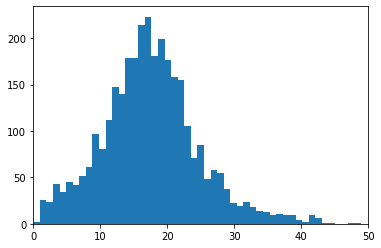

In [51]:
plt.hist(internet_pivot['gb_used_month'], bins=50)
plt.xlim([0,50])
plt.show()

Все таки есть несколько нулевых значений. Проверим сколько их и почему они появились

In [52]:
internet_pivot[internet_pivot['gb_used_month']==0]

,user_id,session_date_month,gb_used_month
592,1094,2018-05,0
2298,1365,2018-10,0


Их всего две. Наверное, они в этом месяце совсем не пользовались интернетом. Оставим эти значения как есть

In [53]:
internet = internet.merge(internet_pivot, on=['user_id', 'session_date_month'], how='left')

In [54]:
internet.head()

,id,mb_used,session_date,user_id,session_date_month,gb_used_month
0,1000_0,112.95,2018-11-25,1000,2018-11,15
1,1000_1,1052.81,2018-09-07,1000,2018-09,15
2,1000_2,1197.26,2018-06-25,1000,2018-06,23
3,1000_3,550.27,2018-08-22,1000,2018-08,14
4,1000_4,302.56,2018-09-24,1000,2018-09,15


## Помесячная выручка с каждого пользователя

Чтобы добавить помесячную выручку с каждого пользователя создадим новую таблицу df, в которую добавим все важные данные из всех наших таблиц

In [55]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [56]:
df = users[['user_id', 'age', 'city', 'tariff']]

In [57]:
df.head()

,user_id,age,city,tariff
0,1000,52,Краснодар,ultra
1,1001,41,Москва,smart
2,1002,59,Стерлитамак,smart
3,1003,23,Москва,ultra
4,1004,68,Новокузнецк,ultra


Чтобы объединение таблиц сработало корректно, переименуем все столбцы с месяцем в одно название - date_month

In [58]:
calls_pivot.rename(columns = {'call_date_month':'date_month'}, inplace = True)

In [59]:
calls_pivot.head()

,user_id,date_month,call_count_month,call_duration_month
0,1000,2018-05,22,151
1,1000,2018-06,43,159
2,1000,2018-07,47,319
3,1000,2018-08,52,390
4,1000,2018-09,58,441


In [60]:
messages_pivot.rename(columns = {'message_date_month':'date_month'}, inplace = True)

In [61]:
messages_pivot.head()

,user_id,date_month,message_count_month
0,1000,2018-05,22
1,1000,2018-06,60
2,1000,2018-07,75
3,1000,2018-08,81
4,1000,2018-09,57


In [62]:
internet_pivot.rename(columns = {'session_date_month':'date_month'}, inplace = True)

In [63]:
internet_pivot.head()

,user_id,date_month,gb_used_month
0,1000,2018-05,3
1,1000,2018-06,23
2,1000,2018-07,14
3,1000,2018-08,14
4,1000,2018-09,15


Теперь можно объединить таблицы)

In [64]:
df = df.merge(internet_pivot, on='user_id', how='outer')

In [65]:
df = df.merge(calls_pivot, on=['user_id', 'date_month'], how='outer')

In [66]:
df = df.merge(messages_pivot, on=['user_id', 'date_month'], how='outer')

In [67]:
df.head()

,user_id,age,city,tariff,date_month,gb_used_month,call_count_month,call_duration_month,message_count_month
0,1000,52.0,Краснодар,ultra,2018-05,3.0,22.0,151.0,22.0
1,1000,52.0,Краснодар,ultra,2018-06,23.0,43.0,159.0,60.0
2,1000,52.0,Краснодар,ultra,2018-07,14.0,47.0,319.0,75.0
3,1000,52.0,Краснодар,ultra,2018-08,14.0,52.0,390.0,81.0
4,1000,52.0,Краснодар,ultra,2018-09,15.0,58.0,441.0,57.0


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3217 entries, 0 to 3216
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype    
---  ------               --------------  -----    
 0   user_id              3217 non-null   int64    
 1   age                  3206 non-null   float64  
 2   city                 3206 non-null   object   
 3   tariff               3206 non-null   object   
 4   date_month           3214 non-null   period[M]
 5   gb_used_month        3203 non-null   float64  
 6   call_count_month     3174 non-null   float64  
 7   call_duration_month  3174 non-null   float64  
 8   message_count_month  2717 non-null   float64  
dtypes: float64(5), int64(1), object(2), period[M](1)
memory usage: 251.3+ KB


Избавимся от пропущенных значений, чтобы они нам не мешали

In [69]:
df = df.dropna().reset_index(drop=True)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype    
---  ------               --------------  -----    
 0   user_id              2667 non-null   int64    
 1   age                  2667 non-null   float64  
 2   city                 2667 non-null   object   
 3   tariff               2667 non-null   object   
 4   date_month           2667 non-null   period[M]
 5   gb_used_month        2667 non-null   float64  
 6   call_count_month     2667 non-null   float64  
 7   call_duration_month  2667 non-null   float64  
 8   message_count_month  2667 non-null   float64  
dtypes: float64(5), int64(1), object(2), period[M](1)
memory usage: 187.6+ KB


Приведем все столбцы к правильному типу данных

In [71]:
df.head()

,user_id,age,city,tariff,date_month,gb_used_month,call_count_month,call_duration_month,message_count_month
0,1000,52.0,Краснодар,ultra,2018-05,3.0,22.0,151.0,22.0
1,1000,52.0,Краснодар,ultra,2018-06,23.0,43.0,159.0,60.0
2,1000,52.0,Краснодар,ultra,2018-07,14.0,47.0,319.0,75.0
3,1000,52.0,Краснодар,ultra,2018-08,14.0,52.0,390.0,81.0
4,1000,52.0,Краснодар,ultra,2018-09,15.0,58.0,441.0,57.0


In [72]:
float_to_int = ['age', 'gb_used_month', 'call_count_month', 'call_count_month', 'message_count_month', 'call_duration_month']

In [73]:
df[float_to_int] = df[float_to_int].astype('int')

In [74]:
df.head()

,user_id,age,city,tariff,date_month,gb_used_month,call_count_month,call_duration_month,message_count_month
0,1000,52,Краснодар,ultra,2018-05,3,22,151,22
1,1000,52,Краснодар,ultra,2018-06,23,43,159,60
2,1000,52,Краснодар,ultra,2018-07,14,47,319,75
3,1000,52,Краснодар,ultra,2018-08,14,52,390,81
4,1000,52,Краснодар,ultra,2018-09,15,58,441,57


Теперь расчитаем помесячную выручку с каждого пользователя и добавим ее в отдельный столбец

In [75]:
def calculate_payment(row):
    
    total_payment = 0 
    
    tariff = row['tariff']
    
    call_duration = row['call_duration_month']
    message_count = row['message_count_month']
    gb_used = row['gb_used_month']
    
    if tariff == 'ultra':
        total_payment += 1950
        if call_duration > 3000:
            total_payment += (call_duration - 3000) * 1
        else:
            total_payment += 0
        if message_count > 1000:
            total_payment += (message_count - 1000) * 1
        else:
            total_payment += 0
        if gb_used > 30:
            total_payment += (gb_used - 30) * 150
        else:
            total_payment += 0
    elif tariff == 'smart':
        total_payment += 550
        if call_duration > 500:
            total_payment += (call_duration - 500) * 3
        else:
            total_payment += 0
        if message_count > 50:
            total_payment += (message_count - 50) * 3
        else:
            total_payment += 0
        if gb_used > 15:
            total_payment += (gb_used - 15) * 200
        else:
            total_payment += 0
    
    return total_payment

In [76]:
df['total_payment'] = df.apply(calculate_payment, axis=1)

In [77]:
df.head(15)

,user_id,age,city,tariff,date_month,gb_used_month,call_count_month,call_duration_month,message_count_month,total_payment
0,1000,52,Краснодар,ultra,2018-05,3,22,151,22,1950
1,1000,52,Краснодар,ultra,2018-06,23,43,159,60,1950
2,1000,52,Краснодар,ultra,2018-07,14,47,319,75,1950
3,1000,52,Краснодар,ultra,2018-08,14,52,390,81,1950
4,1000,52,Краснодар,ultra,2018-09,15,58,441,57,1950
5,1000,52,Краснодар,ultra,2018-10,15,57,329,73,1950
6,1000,52,Краснодар,ultra,2018-11,15,43,320,58,1950
7,1000,52,Краснодар,ultra,2018-12,10,46,313,70,1950
8,1002,59,Стерлитамак,smart,2018-06,11,15,111,4,550
9,1002,59,Стерлитамак,smart,2018-07,18,26,205,11,1150


Наша таблица готова для дальнейшего исследования и анализа!

# Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Поделим нашу таблицу по тарифам

In [78]:
df_ultra = df[df['tariff']=='ultra']

In [79]:
df_smart = df[df['tariff']=='smart']

In [80]:
print(f'''
Тариф 'Ultra'
Средняя продолжительность звонков в месяц: {df_ultra["call_duration_month"].mean()}
Дисперсия продолжительности звонков в месяц: {np.var(df_ultra["call_duration_month"])}
Стандартное отклонение продолжительности звонков в месяц: {np.std(df_ultra["call_duration_month"], ddof=1)}
''')


Тариф 'Ultra'
Средняя продолжительность звонков в месяц: 526.1595744680851
Дисперсия продолжительности звонков в месяц: 86580.86549343598
Стандартное отклонение продолжительности звонков в месяц: 294.44210454832034



In [81]:
print(f'''
Тариф 'Smart'
Средняя продолжительность звонков в месяц: {df_smart["call_duration_month"].mean()}
Дисперсия продолжительности звонков в месяц: {np.var(df_smart["call_duration_month"])}
Стандартное отклонение продолжительности звонков в месяц: {np.std(df_smart["call_duration_month"], ddof=1)}
''')


Тариф 'Smart'
Средняя продолжительность звонков в месяц: 397.86109660574414
Дисперсия продолжительности звонков в месяц: 31513.39480506378
Стандартное отклонение продолжительности звонков в месяц: 177.56649313326352



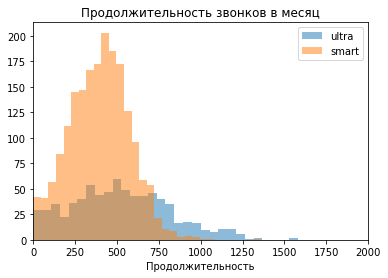

In [82]:
plt.hist(df_ultra["call_duration_month"], alpha=0.5, label='ultra', bins=30)
plt.hist(df_smart["call_duration_month"], alpha=0.5, label='smart', bins=30)
plt.xlim([0, 2000])
plt.title('Продолжительность звонков в месяц')
plt.xlabel('Продолжительность')
plt.legend()
plt.show()

Среднее тарифа Смарт примерно на 100 минут меньше, чем среднее тарифа Ультра. Зато отклонение от среднего меньше. График тарифа Смарт больше скошен в отрицательную сторону, а график Ультра больше в положительную

In [83]:
print(f'''
Тариф 'Ultra'
Среднее кол-во сообщений в месяц: {df_ultra["message_count_month"].mean()}
Дисперсия кол-ва сообщений в месяц: {np.var(df_ultra["message_count_month"])}
Стандартное отклонение кол-ва сообщений в месяц: {np.std(df_ultra["message_count_month"], ddof=1)}
''')


Тариф 'Ultra'
Среднее кол-во сообщений в месяц: 61.640957446808514
Дисперсия кол-ва сообщений в месяц: 2005.8790671684044
Стандартное отклонение кол-ва сообщений в месяц: 44.81684963640807



In [84]:
print(f'''
Тариф 'Smart'
Среднее кол-во сообщений в месяц: {df_smart["message_count_month"].mean()}
Дисперсия кол-ва сообщений в месяц: {np.var(df_smart["message_count_month"])}
Стандартное отклонение кол-ва сообщений в месяц: {np.std(df_smart["message_count_month"], ddof=1)}
''')


Тариф 'Smart'
Среднее кол-во сообщений в месяц: 38.76710182767624
Дисперсия кол-ва сообщений в месяц: 718.4282649687415
Стандартное отклонение кол-ва сообщений в месяц: 26.81051322409091



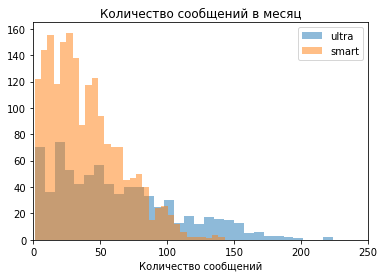

In [85]:
plt.hist(df_ultra["message_count_month"], alpha=0.5, label='ultra', bins=30)
plt.hist(df_smart["message_count_month"], alpha=0.5, label='smart', bins=30)
plt.xlim([0, 250])
plt.title('Количество сообщений в месяц')
plt.xlabel('Количество сообщений')
plt.legend()
plt.show()

Оба графика скошены вправо. Опять же отклонение от среднего в тарифе Ультра больше

In [86]:
print(f'''
Тариф 'Ultra'
Средний объем интернет-трафика (гб) в месяц: {df_ultra["gb_used_month"].mean()}
Дисперсия интернет-трафика (гб) в месяц: {np.var(df_ultra["gb_used_month"])}
Стандартное отклонение интернет-трафика (гб) в месяц: {np.std(df_ultra["gb_used_month"], ddof=1)}
''')


Тариф 'Ultra'
Средний объем интернет-трафика (гб) в месяц: 19.618351063829788
Дисперсия интернет-трафика (гб) в месяц: 88.01524834483911
Стандартное отклонение интернет-трафика (гб) в месяц: 9.387888247422698



In [87]:
print(f'''
Тариф 'Smart'
Средний объем интернет-трафика (гб) в месяц: {df_smart["gb_used_month"].mean()}
Дисперсия интернет-трафика (гб) в месяц: {np.var(df_smart["gb_used_month"])}
Стандартное отклонение интернет-трафика (гб) в месяц: {np.std(df_smart["gb_used_month"], ddof=1)}
''')


Тариф 'Smart'
Средний объем интернет-трафика (гб) в месяц: 16.362924281984334
Дисперсия интернет-трафика (гб) в месяц: 32.1466149472699
Стандартное отклонение интернет-трафика (гб) в месяц: 5.671279437822774



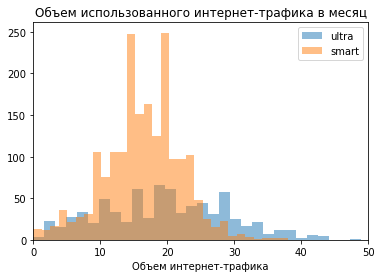

In [88]:
plt.hist(df_ultra["gb_used_month"], alpha=0.5, label='ultra', bins=30)
plt.hist(df_smart["gb_used_month"], alpha=0.5, label='smart', bins=30)
plt.xlim([0, 50])
plt.title('Объем использованного интернет-трафика в месяц')
plt.xlabel('Объем интернет-трафика')
plt.legend()
plt.show()

Оба графика распределены нормальным образом. Видны резкие скачки в некоторых значениях. Пользователи обоих тарифов потребляют почти одинаковое кол-во интернет-трафика

# Проверка гипотез

## Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Нулевая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются

Альтернативная гипотеза - средняя выручка отличается

In [89]:
alpha = 0.05  
results = st.ttest_ind(df_ultra['total_payment'], df_smart['total_payment'])
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.0087590178304795e-133
Отвергаем нулевую гипотезу


Вероятность правильности нулевой гипотезы невероятно мала. Значит средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [90]:
df.groupby('tariff')['total_payment'].mean()

tariff
smart    1257.947258
ultra    2048.936170
Name: total_payment, dtype: float64

Тариф Ультра приносит больше денег. Что и следовало ожидать

## Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

Альтернативная гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [91]:
df_moscow = df[df['city']=='Москва']

In [92]:
df_moscow.head()

,user_id,age,city,tariff,date_month,gb_used_month,call_count_month,call_duration_month,message_count_month,total_payment
15,1003,23,Москва,ultra,2018-08,9,55,356,37,1950
16,1003,23,Москва,ultra,2018-09,13,134,905,91,1950
17,1003,23,Москва,ultra,2018-10,15,108,810,83,1950
18,1003,23,Москва,ultra,2018-11,12,115,776,94,1950
19,1003,23,Москва,ultra,2018-12,10,108,756,75,1950


In [93]:
df_other_city = df[df['city']!='Москва']

In [94]:
df_other_city.head()

,user_id,age,city,tariff,date_month,gb_used_month,call_count_month,call_duration_month,message_count_month,total_payment
0,1000,52,Краснодар,ultra,2018-05,3,22,151,22,1950
1,1000,52,Краснодар,ultra,2018-06,23,43,159,60,1950
2,1000,52,Краснодар,ultra,2018-07,14,47,319,75,1950
3,1000,52,Краснодар,ultra,2018-08,14,52,390,81,1950
4,1000,52,Краснодар,ultra,2018-09,15,58,441,57,1950


In [95]:
alpha = 0.05  
results = st.ttest_ind(df_moscow['total_payment'], df_other_city['total_payment'])
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.08244090114571569
Не получилось отвергнуть нулевую гипотезу


Значит пользователи в Москве приносят почти ту же выручку, как и в других регионах

In [96]:
df_moscow['total_payment'].mean()

1536.8696537678209

In [97]:
df_other_city['total_payment'].mean()

1468.3667279411766

В Москве выручка в месяц от одного пользователя в среднем на 68 рублей больше

# Какой же тариф лучше?

In [98]:
df.head()

,user_id,age,city,tariff,date_month,gb_used_month,call_count_month,call_duration_month,message_count_month,total_payment
0,1000,52,Краснодар,ultra,2018-05,3,22,151,22,1950
1,1000,52,Краснодар,ultra,2018-06,23,43,159,60,1950
2,1000,52,Краснодар,ultra,2018-07,14,47,319,75,1950
3,1000,52,Краснодар,ultra,2018-08,14,52,390,81,1950
4,1000,52,Краснодар,ultra,2018-09,15,58,441,57,1950


In [99]:
df.query('tariff == "ultra" and total_payment > 1950')['total_payment'].mean() - 1950

817.5824175824177

In [100]:
df.query('tariff == "smart" and total_payment > 550')['total_payment'].mean() - 550

960.1409348441925

Тариф Смарт приносит больше дополнительной прибыли!

In [101]:
df.groupby('tariff')['total_payment'].agg(['count', 'mean'])

,count,mean
tariff,,
smart,1915,1257.947258
ultra,752,2048.936170


Тариф Ультра в среднем приносит в два раза больше выручки. Но тариф Смарт выбирают в 3 раза больше пользователей

In [102]:
df.groupby('tariff')['total_payment'].sum()

tariff
smart    2408969
ultra    1540800
Name: total_payment, dtype: int64

В нашей выборке тариф Смарт принес больше выручки

# Вывод

Мы провели исследование по данным о пользователях компании Мегалайн и проверили статистические гипотезы. И пришли к таким выводам:
1. Поведение пользователей обоих тарифов почти не отличается. Они потребляют столько же трафика (звонки, смс, интернет), но среднее тарифа Ультра больше из-за наличия больших выбросов. Некоторые пользователи этого тарифа стараются использовать все имеющиеся преимущества, но все равно почти никто не доходит до лимита. 
2. Трафик больше всех выходящий за лимит - интернет. Почти половина пользователей тарифа Смарт переходят за границу лимита
3. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Тариф Ультра в среднем приносит в два раза больше выручки.
4. Тариф Смарт выбирают в 3 раза больше пользователей.
5. Тариф Смарт приносит больше дополнительной прибыли. Примерно на 150 рублей
6. Тариф Смарт приносит больше выручки в общем объеме

Исходя из наших выводов, тариф Смарт лучше чем Ультра. Его выбирают больше пользователей, он приносит больше доп. выручки и в общем объеме тоже принес больше денег